<a href="https://colab.research.google.com/github/SheryllD/diabetic_retinopathy_ml/blob/main/Diabetic_Retinopathy_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# New section

# Preprossesing

In [30]:
# Install Kaggle API
!pip install Kaggle

In [31]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle (3).json


{'kaggle (3).json': b'{"username":"sherylld","key":"afc6369cec9abe533092d78fb0726192"}'}

In [33]:
# Moving it in the right location
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d tanlikesmath/diabetic-retinopathy-resized --unzip

Dataset URL: https://www.kaggle.com/datasets/tanlikesmath/diabetic-retinopathy-resized
License(s): unknown
^C


In [34]:
# Importing kaggle
import kagglehub

# Download latest version
path = kagglehub.dataset_download("tanlikesmath/diabetic-retinopathy-resized")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/diabetic-retinopathy-resized


In [6]:
# !kaggle datasets list | head

### Libraries

In [83]:
# Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import os
from PIL import Image

import tensorflow as tf

from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras import layers, models
from tensorflow.keras.applications import EfficientNetB0


In [36]:
# Reviewing the paths
print("Downloaded path:", path)
print("Contents of the folder:")
print(os.listdir(path))

Downloaded path: /kaggle/input/diabetic-retinopathy-resized
Contents of the folder:
['resized_train', 'trainLabels.csv', 'resized_train_cropped', 'trainLabels_cropped.csv']


In [41]:
# base_path = "/root/.cache/kagglehub/datasets/tanlikesmath/diabetic-retinopathy-resized/versions/7"
# print("Contents:", os.listdir(base_path))

base_path = "/kaggle/input/diabetic-retinopathy-resized"
print("Contents:", os.listdir(base_path))

Contents: ['resized_train', 'trainLabels.csv', 'resized_train_cropped', 'trainLabels_cropped.csv']


In [54]:
# I am using the cropped images to reduce the noise

df_images = os.path.join(base_path, "resized_train_cropped", "resized_train_cropped")
df_labels = os.path.join(base_path, "trainLabels_cropped.csv")

print("Images folder: ", df_images)
print("Labels file:", df_labels)

Images folder:  /kaggle/input/diabetic-retinopathy-resized/resized_train_cropped/resized_train_cropped
Labels file: /kaggle/input/diabetic-retinopathy-resized/trainLabels_cropped.csv


In [55]:
# Loading the CSV
df_labels = pd.read_csv(labels)
print(df_labels.head())

   Unnamed: 0.1  Unnamed: 0     image  level
0             0           0   10_left      0
1             1           1  10_right      0
2             2           2   13_left      0
3             3           3  13_right      0
4             4           4   15_left      1


In [56]:
# Reviewing the basic info
df_labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35108 entries, 0 to 35107
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Unnamed: 0.1  35108 non-null  int64 
 1   Unnamed: 0    35108 non-null  int64 
 2   image         35108 non-null  object
 3   level         35108 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 1.1+ MB


In [57]:
df_labels.describe()

,Unnamed: 0.1,Unnamed: 0,level
count,35108.000000,35108.000000,35108.000000
mean,17553.520992,17563.923778,0.525863
std,10134.986560,10139.840349,0.970372
min,0.000000,0.000000,0.000000
25%,8776.750000,8783.750000,0.000000
50%,17553.500000,17565.500000,0.000000
75%,26330.250000,26345.250000,1.000000
max,35108.000000,35125.000000,4.000000


In [58]:
# How many missing?
df_labels.isna().sum()

,0
Unnamed: 0.1,0
Unnamed: 0,0
image,0
level,0


In [59]:
# How many duplicated?
df_labels.duplicated()

,0
0,False
1,False
2,False
3,False
4,False
...,...
35103,False
35104,False
35105,False
35106,False


In [60]:
df_num_columns = df_labels.select_dtypes(include="number")
df_num_columns

,Unnamed: 0.1,Unnamed: 0,level
0,0,0,0
1,1,1,0
2,2,2,0
3,3,3,0
4,4,4,1
...,...,...,...
35103,35104,35121,0
35104,35105,35122,0
35105,35106,35123,0
35106,35107,35124,0


In [61]:
df_num_columns.corr()

,Unnamed: 0.1,Unnamed: 0,level
Unnamed: 0.1,1.00000,1.000000,-0.007790
Unnamed: 0,1.00000,1.000000,-0.007789
level,-0.00779,-0.007789,1.000000


In [62]:
# How many classes?
print("Unique labels", df_labels['level'].unique())
print("Class distribution:\n", df_labels["level"].value_counts())

Unique labels [0 1 2 4 3]
Class distribution:
 level
0    25802
2     5288
1     2438
3      872
4      708
Name: count, dtype: int64


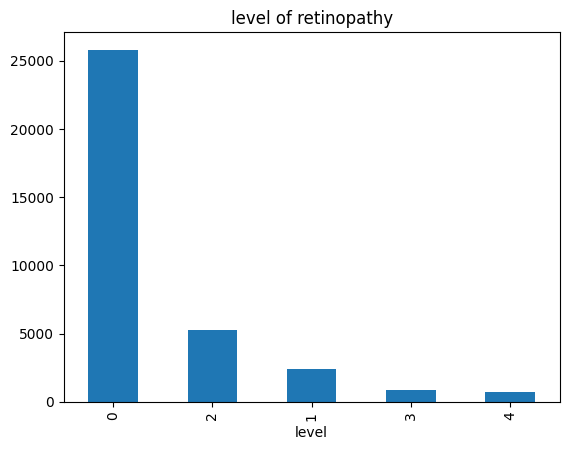

In [63]:
df_labels["level"].value_counts().plot(kind="bar")
plt.title("level of retinopathy")
plt.ylabel("")
plt.show()

0 → no DR
1 → mild
2 → moderate
3 → severe
4 → proliferative

I can see that the data is very imbalanced.

### Reviewing the **images**

In [64]:
# Confirming folder variable
print("Images folder path:", df_images)
print("Example files inside:", os.listdir(df_images)[:5])

Images folder path: /kaggle/input/diabetic-retinopathy-resized/resized_train_cropped/resized_train_cropped
Example files inside: ['81_right.jpeg', '17169_left.jpeg', '38111_right.jpeg', '23964_left.jpeg', '13170_left.jpeg']


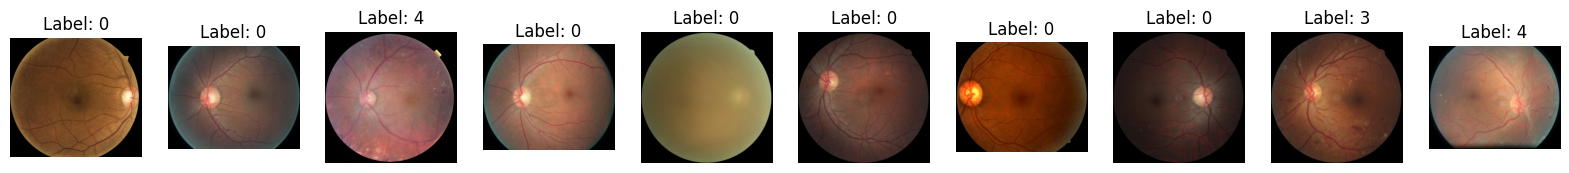

In [65]:
# picking random images
sample = df_labels.sample(10, random_state=42)

# plotting 5 random samples side by side for better overview
fig, axes = plt.subplots(1, 10, figsize=(20, 5))

for ax, (_, row) in zip(axes, sample.iterrows()):
    img_path = os.path.join(df_images, row['image'] + '.jpeg')
    img = Image.open(img_path)
    ax.imshow(img)
    ax.set_title(f"Label: {row['level']}")
    ax.axis('off')
plt.show()

# for idx, row in sample.iterrows():
#   img_path = os.path.join(df_images, row['image'] + '.jpeg')
#   img = Image.open(img_path)
#   plt.imshow(img)
#   plt.title(f"Label: {row['level']}")
#   plt.axis("off")
#   plt.show()

In [66]:
# resizing the images

image_size = 224
batch_size = 32
num_classes = df_labels['level'].unique()

print(f"Image size: {image_size}x{image_size}")
print(f"Number of classes: {num_classes}")

Image size: 224x224
Number of classes: [0 1 2 4 3]


In [67]:
# Adding image path to the label Dataframe
df_labels["path"] = df_labels["image"].apply(lambda x: os.path.join(df_images, x + ".jpeg"))

In [68]:
# Reviewing
df_labels.head()

,Unnamed: 0.1,Unnamed: 0,image,level,path
0,0,0,10_left,0,/kaggle/input/diabetic-retinopathy-resized/res...
1,1,1,10_right,0,/kaggle/input/diabetic-retinopathy-resized/res...
2,2,2,13_left,0,/kaggle/input/diabetic-retinopathy-resized/res...
3,3,3,13_right,0,/kaggle/input/diabetic-retinopathy-resized/res...
4,4,4,15_left,1,/kaggle/input/diabetic-retinopathy-resized/res...


In [69]:
# Reviewing Tensorflow version
print(tf.__version__)

2.18.0


# Splitting into train and validation sets

In [70]:
# Splitting it into 80% training and 20% validation (stratify to keep label balance)
df_train, df_val = train_test_split(df_labels, test_size=0.2, stratify = df_labels['level'], random_state=42)

print(f"Train set: {len(df_train)} images")
print(f"Validation set: {len(df_val)} images")

Train set: 28086 images
Validation set: 7022 images


In [72]:
# Turning the splits into tf.data.Dataset

# Parsing function
def parse_image(filename, label):
  image = tf.io.read_file(filename)
  image = tf.image.decode_jpeg(image, channels=3)
  image = tf.image.resize(image, [224, 224])
  image = image / 255.0
  return image, label

### Training the dataset

In [73]:
train_ds = tf.data.Dataset.from_tensor_slices((df_train['path'].values, df_train['level'].values))
train_ds = train_ds.map(parse_image, num_parallel_calls=tf.data.AUTOTUNE)
train_ds = train_ds.shuffle(1024).batch(32).prefetch(tf.data.AUTOTUNE)

### Validation dataset

In [74]:
val_ds = tf.data.Dataset.from_tensor_slices((df_val['path'].values, df_val['level'].values))
val_ds = val_ds.map(parse_image, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)

In [75]:
# Inspecting 1 batch

for images, labels in train_ds.take(1):
  print(f"Images shape:", images.shape)
  print(f"Labels shape:", labels.shape)

Images shape: (32, 224, 224, 3)
Labels shape: (32,)


### Computing class_weight

In [82]:
# Get unique classes
classes = np.unique(df_labels['level'])
print("Classes:", classes)

# computing weights
weights = compute_class_weight(
    class_weight = 'balanced',
    classes = classes,
    y = df_train['level']
)

# Making dictionary for Keras
class_weight = dict(zip(classes, weights))
print("Classweights:", class_weight)

Classes: [0 1 2 3 4]
Classweights: {np.int64(0): np.float64(0.27213797781115256), np.int64(1): np.float64(2.8806153846153846), np.int64(2): np.float64(1.3279432624113474), np.int64(3): np.float64(8.04756446991404), np.int64(4): np.float64(9.906878306878307)}


### Building & Compiling the model

In [87]:
# Loading the basemodel
base_model = EfficientNetB0(
    input_shape = (224, 224, 3),
    include_top = False,
    weights='imagenet'
)
base_model.trainable = False

# Building head
inputs = layers.Input(shape=(224, 224, 3))
x = base_model(inputs, training = False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.2)(x)
outputs = layers.Dense(5, activation='softmax')(x)

model = models.Model(inputs, outputs)

# Compiling the model

model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │         6,405 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,055,976 (15.47 MB)

 Trainable params: 6,405 (25.02 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

### Training the model

### Evaluate